<a href="https://colab.research.google.com/github/cdbolivarz/Accidentality_Predictions_Medellin/blob/master/Limpieza__y_formato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza y formato de datos
En este documento, se realiza el preprocesamiento de los datos obtenidos de los documentos de incidentes georeferenciados.

Librerias

In [102]:
# !pip install holidays_co
import pandas as pd
import glob
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
# import holidays_co

### Lectura de datos

In [103]:
all_files = glob.glob("dataset/I*.csv")

li = []

for filename in all_files:

    frame = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df = df.sort_values(by=["FECHA"])

df.head()

,X,Y,OBJECTID,RADICADO,FECHA,HORA,DIA,PERIODO,CLASE,DIRECCION,DIRECCION_ENC,CBML,TIPO_GEOCOD,GRAVEDAD,BARRIO,COMUNA,DISENO,DIA_NOMBRE,MES,MES_NOMBRE,X_MAGNAMED,Y_MAGNAMED,LONGITUD,LATITUD
136791,-75.703816,6.221806,211342,1424116,2014/01/01 00:00:00+00,05:30:00,1,2014,Atropello,Con,000 00000,NaN,No Ubicada,HERIDO,NaN,NaN,Lote o Predio,MIÉRCOLES,1,NaN,820000.00,1180000.00,-75.703816,6.221806
136790,-75.579329,6.209160,211341,1424110,2014/01/01 00:00:00+00,04:20:00,1,2014,Choque,CR 50 CL 4,CR 050 004 000 00000,1507,Malla vial,HERIDO,Campo Amor,Guayabal,Tramo de via,MIÉRCOLES,1,NaN,833779.95,1178599.23,-75.579329,6.209160
136789,-75.565164,6.242722,211340,1424107,2014/01/01 00:00:00+00,09:10:00,1,2014,Choque,CL 44 CR 43,CL 044 043 000 00000,1013,Malla vial,HERIDO,Barrio Colón,La Candelaria,Interseccion,MIÉRCOLES,1,NaN,835348.01,1182311.63,-75.565164,6.242722
136788,-75.555400,6.252163,211339,1424101,2014/01/01 00:00:00+00,08:50:00,1,2014,Choque,CR 39 CL 60,CR 039 060 000 00000,0803,Malla vial,HERIDO,San Miguel,Villa Hermosa,Tramo de via,MIÉRCOLES,1,NaN,836428.72,1183355.92,-75.555400,6.252163
136787,-75.564683,6.249282,211338,1424096,2014/01/01 00:00:00+00,08:00:00,1,2014,Otro,CL 52 CR 46,CL 052 046 000 00000,1019,Malla vial,HERIDO,La Candelaria,La Candelaria,Tramo de via,MIÉRCOLES,1,NaN,835401.20,1183037.23,-75.564683,6.249282


Que columnas tienen valores nulos

In [104]:
df.isna().any()

X                False
Y                False
OBJECTID         False
RADICADO          True
FECHA            False
HORA             False
DIA              False
PERIODO          False
CLASE             True
DIRECCION        False
DIRECCION_ENC     True
CBML              True
TIPO_GEOCOD      False
GRAVEDAD         False
BARRIO            True
COMUNA            True
DISENO            True
DIA_NOMBRE       False
MES              False
MES_NOMBRE        True
X_MAGNAMED       False
Y_MAGNAMED       False
LONGITUD         False
LATITUD          False
dtype: bool

Formato datos

In [105]:
#Eliminar filas con NA y columnas que no consideramos importantes para el modelo.
#Asignar mismos nombres a los tipos de accidentes (CLASE)
def format(df):
  df = df.drop(['X', 'Y', 'OBJECTID', 'RADICADO', 'DIRECCION', 'DIRECCION_ENC',
              'CBML', 'TIPO_GEOCOD', 'DISENO', 'MES_NOMBRE', 'X_MAGNAMED',
              'Y_MAGNAMED'], axis=1)
  df = df.dropna(subset=['CLASE', 'BARRIO', 'COMUNA'])

  df["CLASE"].replace({"Caída de Ocupante": "Caida Ocupante",
                       "Caida de Ocupante": "Caida Ocupante",
                       "Caída Ocupante": "Caida Ocupante",
                       "Choque ": "Choque"}, inplace=True)

  return df

df = format(df)
df.columns = df.columns.str.lower()
df = df.reset_index()
df = df.drop(['index'],axis=1)
df.head()

,fecha,hora,dia,periodo,clase,gravedad,barrio,comuna,dia_nombre,mes,longitud,latitud
0,2014/01/01 00:00:00+00,04:20:00,1,2014,Choque,HERIDO,Campo Amor,Guayabal,MIÉRCOLES,1,-75.579329,6.209160
1,2014/01/01 00:00:00+00,09:10:00,1,2014,Choque,HERIDO,Barrio Colón,La Candelaria,MIÉRCOLES,1,-75.565164,6.242722
2,2014/01/01 00:00:00+00,08:50:00,1,2014,Choque,HERIDO,San Miguel,Villa Hermosa,MIÉRCOLES,1,-75.555400,6.252163
3,2014/01/01 00:00:00+00,08:00:00,1,2014,Otro,HERIDO,La Candelaria,La Candelaria,MIÉRCOLES,1,-75.564683,6.249282
4,2014/01/01 00:00:00+00,10:00:00,1,2014,Choque,HERIDO,La Milagrosa,Buenos Aires,MIÉRCOLES,1,-75.557573,6.235498


## Fechas

Primero se cambia el timpo de la comuna *fecha* por el tipo **datetime**

In [106]:
fechas = df['fecha']
df['fecha'] = pd.to_datetime(fechas)

Luego se crea la columna *dia_anno* para saber a que dia del año pertenece cada fila y la columna semana donde va la semana del año


In [107]:
df['dia_anno']=df['fecha'].dt.dayofyear
df['semana']=df['fecha'].dt.isocalendar().week

In [108]:
df.head()

,fecha,hora,dia,periodo,clase,gravedad,barrio,comuna,dia_nombre,mes,longitud,latitud,dia_anno,semana
0,2014-01-01 00:00:00+00:00,04:20:00,1,2014,Choque,HERIDO,Campo Amor,Guayabal,MIÉRCOLES,1,-75.579329,6.209160,1,1
1,2014-01-01 00:00:00+00:00,09:10:00,1,2014,Choque,HERIDO,Barrio Colón,La Candelaria,MIÉRCOLES,1,-75.565164,6.242722,1,1
2,2014-01-01 00:00:00+00:00,08:50:00,1,2014,Choque,HERIDO,San Miguel,Villa Hermosa,MIÉRCOLES,1,-75.555400,6.252163,1,1
3,2014-01-01 00:00:00+00:00,08:00:00,1,2014,Otro,HERIDO,La Candelaria,La Candelaria,MIÉRCOLES,1,-75.564683,6.249282,1,1
4,2014-01-01 00:00:00+00:00,10:00:00,1,2014,Choque,HERIDO,La Milagrosa,Buenos Aires,MIÉRCOLES,1,-75.557573,6.235498,1,1


Haciendo uso de la libreria _**holidays_co**_ se creo un archivo *festivos.csv* que contiene las fechas y si la fecha es festivo o no, para hacer un join con el dataframe actual, ya que la ejecucion de esta libreria toma al rededor de 5min

In [109]:
# codigo empleadon holidays_co
# def festivo(row):
#     row['festivo'] = holidays_co.is_holiday_date(row['fecha'])
#     return row
# dfcopy = dfcopy.apply(festivo, axis=1)

In [110]:
festivos = pd.read_csv('dataset/festivos.csv')
df = df.join(festivos['festivo'])

Filas con errores ortograficos en algunas columnas

In [111]:
df['comuna'].drop_duplicates()

0                                           Guayabal
1                                      La Candelaria
2                                      Villa Hermosa
4                                       Buenos Aires
5                                            Popular
6                                           Aranjuez
7                                            Robledo
9                                   Laureles Estadio
10                                   Doce de Octubre
16                                          Manrique
18                                             Belén
19                                          Castilla
43                                        El Poblado
54             Corregimiento de San Antonio de Prado
60                                        San Javier
62                                        La América
70                    Corregimiento de San Cristóbal
132                                       Santa Cruz
201                       Corregimiento de Alt

In [112]:
df['barrio'].drop_duplicates()

0                                       Campo Amor
1                                     Barrio Colón
2                                       San Miguel
3                                    La Candelaria
4                                     La Milagrosa
5                                        San Pablo
6                                         Brasilia
7                                      Villa Flora
8                                       Aures No.1
9                                    La Castellana
10                                         Kennedy
12                                     El Diamante
13                                 Bello Horizonte
14                            Alejandro Echavarría
15                                     La Pilarica
16                                 Versalles No. 1
17                              Campo Valdés No. 2
18                                    La Hondonada
19                                         Toscana
20                             

In [113]:
df.head()

,fecha,hora,dia,periodo,clase,gravedad,barrio,comuna,dia_nombre,mes,longitud,latitud,dia_anno,semana,festivo
0,2014-01-01 00:00:00+00:00,04:20:00,1,2014,Choque,HERIDO,Campo Amor,Guayabal,MIÉRCOLES,1,-75.579329,6.209160,1,1,True
1,2014-01-01 00:00:00+00:00,09:10:00,1,2014,Choque,HERIDO,Barrio Colón,La Candelaria,MIÉRCOLES,1,-75.565164,6.242722,1,1,True
2,2014-01-01 00:00:00+00:00,08:50:00,1,2014,Choque,HERIDO,San Miguel,Villa Hermosa,MIÉRCOLES,1,-75.555400,6.252163,1,1,True
3,2014-01-01 00:00:00+00:00,08:00:00,1,2014,Otro,HERIDO,La Candelaria,La Candelaria,MIÉRCOLES,1,-75.564683,6.249282,1,1,True
4,2014-01-01 00:00:00+00:00,10:00:00,1,2014,Choque,HERIDO,La Milagrosa,Buenos Aires,MIÉRCOLES,1,-75.557573,6.235498,1,1,True


In [114]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
len(df['barrio'].drop_duplicates())

339

Todos las columnas de *clase, gravedad, barrio, comuna, dia_nombre* se pasaron a miniuscula para evitar posibles inconveniesntes futuros

In [115]:
df['clase'] = df['clase'].str.lower()
df['gravedad'] = df['gravedad'].str.lower()
df['barrio'] = df['barrio'].str.lower()
df['comuna'] = df['comuna'].str.lower()
df['dia_nombre'] = df['dia_nombre'].str.lower()

## Barrios


Se eliminan las filas donde el barrio sale como un número

In [116]:
for barrio in df['barrio']:
    try:
        int(barrio)
        df = df.replace({'barrio': barrio}, np.nan)
    except:
        pass
df= df.dropna(subset=['barrio'])

Para corregir los barrios donde salía **no. #**  para que salga **no.#**

In [117]:
def error_no(row):
    barrio = row['barrio'].strip()
    b = bool(re.search(r'(no)\. \d', barrio))
    if (b):
        b = barrio.split()
        barrio = ' '.join(b[0:-2])
        barrio += ' '+b[-2]+b[-1]
    row['barrio'] = barrio
    return row
df = df.apply(error_no,axis=1)

In [118]:
# Barrios con problemas
# en Medellin se supone hay 275 barrio (segun wikipedia)

# hay varios suburbanos que me parecen raros
# el barrio 'u.p.b'
# creo que todos los barrios que se llaman universidad algo estan mal (el de falcultad de minas existe)


In [119]:
df = df.replace({'barrio':{'barrio de jesús':'barrios de jesús',
                                   'berlin':'berlín',
                                   'inst':np.nan,
                                   'loma de los bernal':'la loma de los bernal',
                                   'villa liliam':'villa lilliam'}})

In [120]:
barrios = df['barrio'].sort_values().unique()


In [121]:
len(barrios)

317

## Comunas

In [122]:
# 1	Comuna 1 - Popular
# 2	Comuna 2 - Santa Cruz
# 3	Comuna 3 - Manrique
# 4	Comuna 4 - Aranjuez
# 5	Comuna 5 - Castilla
# 6	Comuna 6 - Doce de Octubre
# 7	Comuna 7 - Robledo
# 8	Comuna 8 - Villa Hermosa
# 9	Comuna 9 - Buenos Aires
# 10 Comuna 10 - La Candelaria
# 11 Comuna 11 - Laureles-Estadio
# 12 Comuna 12 - La América
# 13 Comuna 13 - San Javier
# 14 Comuna 14 - El Poblado
# 15 Comuna 15 - Guayabal
# 16 Comuna 16 - Belén

In [123]:
df = df.replace({'comuna':{ 'alejandro echavarría': 'buenos aires',
                                    'alfonso lópez':'castilla',
                                    'altavista':'belén',
                                    'andalucía':'santa cruz',
                                    'antonio nariño':'san javier',
                                    'au':np.nan,
                                    'barrio colón':'la candelaria',
                                    'bolivariana':'laureles-estadio',
                                    'boston':'la candelaria',
                                    'cabecera san antonio de prado':'corregimiento san antorio de prado',
                                    'calasanz':'la américa',
                                    'calle nueva':'la candelaria',
                                    'campo amor':'guayabal',
                                    'campo valdés no. 1':'aranjuez',
                                    'campo valdés no. 2':'manrique',
                                    'caribe':'castilla',
                                    'cerro nutibara':'belén',
                                    'corazón de jesús':'la candelaria',
                                    'cristo rey':'guayabal',
                                    'el chagualo':'la candelaria',
                                    'el nogal-los almendros':'belén',
                                    'el raizal':'manrique',
                                    'estación villa':'la candelaria',
                                    'florida nueva':'laureles-estadio',
                                    'fátima':'belén',
                                    'girardot':'castilla',
                                    'guayaquil':'la candelaria',
                                    'héctor abad gómez':'castilla'}})

In [124]:
df = df.replace({'comuna':{'in':np.nan, 
                                'jesús nazareno':'la candelaria',
                                'la alpujarra':np.nan,
                                'la colina':'guayabal',
                                'la floresta':'la américa',
                                'la rosa':'santa cruz',
                                'las esmeraldas':'aranjuez',
                                'las granjas':'manrique',
                                'las palmas':'la candelaria',
                                'las playas':'belén',
                                'laureles':'laureles-estadio',
                                'laureles estadio':'laureles-estadio', 
                                'los conquistadores':'laureles-estadio',
                                'los mangos':'villa hermosa',
                                'manila':'el poblado',
                                'miranda':'aranjuez',
                                'moravia':'aranjuez',
                                'naranjal':'laureles-estadio',
                                'oleoducto':np.nan,
                                'parque juan pablo ii':'buenos aires',
                                'patio bonito':'el poblado',
                                'perpetuo socorro':'la candelaria',
                                'rosales':'belén',
                                'san pedro':'aranjuez',
                                'santa fé':'guayabal',
                                'santa inés':'manrique',
                                'santa maría de los ángeles':'el poblado',
                                'simón bolívar':'la américa',
                                'sn':np.nan,
                                'suramericana':'laureles-estadio',
                                'toscana':'castilla',
                                'universidad de antioquia':np.nan,
                                'veinte de julio':'san javier',
                                'villa carlota':'el poblado',
                                'villa guadalupe':'popular'}})

In [125]:
comunas = df['comuna'].sort_values().unique()
comunas

array(['aranjuez', 'belén', 'buenos aires', 'castilla',
       'corregimiento de altavista',
       'corregimiento de san antonio de prado',
       'corregimiento de san cristóbal',
       'corregimiento de san sebastián de palmitas',
       'corregimiento de santa elena',
       'corregimiento san antorio de prado', 'doce de octubre',
       'el poblado', 'guayabal', 'la américa', 'la candelaria',
       'laureles-estadio', 'manrique', 'popular', 'robledo', 'san javier',
       'santa cruz', 'villa hermosa', nan], dtype=object)

## Longitud y latitud

Para ver que tal estan los valores de longitud y latitud se realiza un grafico para ver que puntos estan más alejados dependiendo de la comuna que tienen

In [180]:
# colores = ['blue','red','green','cyan','yellow','orange','black','pink','purple']
colores = ['#F3E9DC','#C08552','#5E3023','#9EADC8','#DAB49D','#40798C','#EC058E',
           '#386C0B','#462255','#C3F3C0','#7B0D1E','#01FDF6','#E9DF00','#FB5012','#EC9A29','#2176FF']
dic = {
    'popular':0,
    'santa cruz':1,
    'manrique':2,
    'aranjuez':3,
    'castilla':4,
    'doce de octubre':5,
    'robledo':6,
    'villa hermosa':7,
    'buenos aires':8,
    'la candelaria':9,
    'laureles-estadio':10,
    'la américa':11,
    'san javier':12,
    'el poblado':13,
    'guayabal':14,
    'belén':15
}

asignacion = []
for row in df['comuna'].values:
    try:
        asignacion.append(colores[dic[row]])
    except:
        asignacion.append('black')

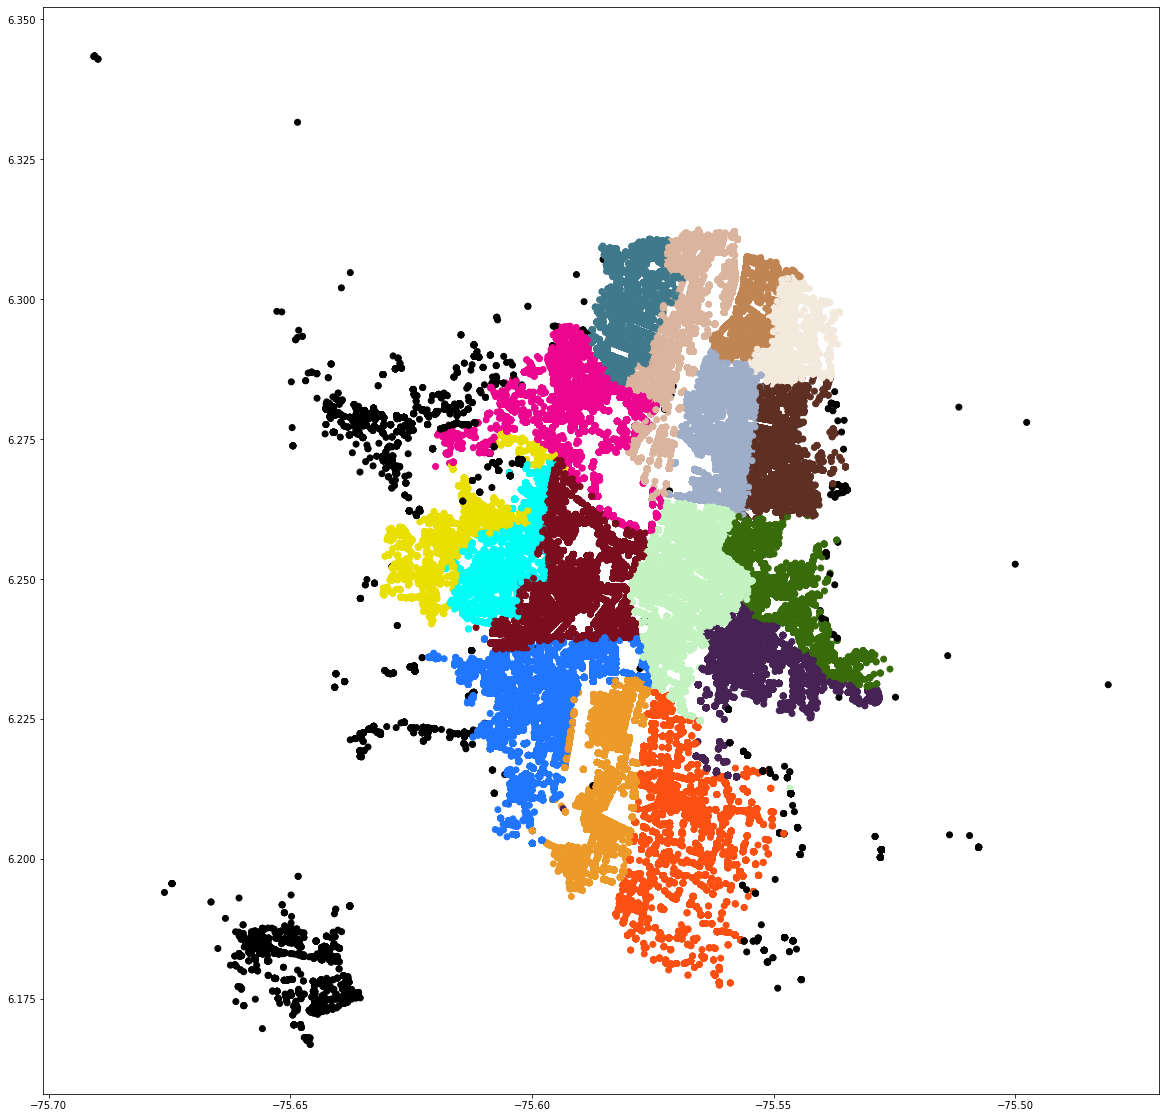

In [183]:
x = list(df['longitud'])
y = list(df['latitud'])
plt.figure(figsize=(20,20))
plt.scatter(x,y,c=asignacion)